In [ ]:
import numpy as np
import nibabel as nib
from sklearn.decomposition import PCA
from scipy.ndimage import binary_erosion
import trimesh
import os

def load_mask(path):
    img = nib.load(path)
    mask = img.get_fdata().astype(bool)
    return mask, img.affine

def compute_midline_pca(mask, affine):
   
    mask_proc = binary_erosion(mask, iterations=1)

    coords = np.column_stack(np.nonzero(mask_proc))
    coords_mm = nib.affines.apply_affine(affine, coords)

    pca = PCA(n_components=3)
    pca.fit(coords_mm)
    centroid = pca.mean_

    idx = np.argmin(pca.explained_variance_)
    normal = pca.components_[idx]
    normal = normal / np.linalg.norm(normal)

    return centroid, normal

def make_midline_line(centroid, normal, length=300, n_points=200):
   
    v = np.array([1.0, 0.0, 0.0])
    if np.allclose(np.abs(np.dot(v, normal)), 1.0):
        v = np.array([0.0, 1.0, 0.0])

    dir1 = v - np.dot(v, normal) * normal
    dir1 /= np.linalg.norm(dir1)
    ts = np.linspace(-length/2, length/2, n_points)
    line_pts = np.array([centroid + t*dir1 for t in ts])
    return line_pts

def lps_to_ras(points):
    ras = points.copy()
    ras[:, 0] *= -1  # L->R
    ras[:, 1] *= -1  # P->A
    return ras

def save_csv(points, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    np.savetxt(path, points, delimiter=",", header="x,y,z", comments='')
    print("Saved CSV:", path)

def save_stl(points, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    mesh = trimesh.load_path(points)
    mesh.export(path)
    print("Saved STL:", path)

skull_path = r"Z:\FacialDeformation_MPhys\rhabdo_data_proton\DICOMS\abby\UIDQQ0x7axQ0Q1\asymmetry\skull.nii.gz"

skull_mask, skull_affine = load_mask(skull_path)

centroid, normal = compute_midline_pca(skull_mask, skull_affine)
print("Centroid:", centroid)
print("Normal:", normal)

midline_pts = make_midline_line(centroid, normal, length=300, n_points=200)

csv_path = r"Z:\FacialDeformation_MPhys\rhabdo_data_proton\DICOMS\abby\UIDQQ0x7axQ0Q1\asymmetry\midline_pts.csv"

save_csv(midline_pts, csv_path)

Centroid: [ 6.80875042 -2.86297667 -0.67524526]
Normal: [ 0.98162283 -0.10801824  0.1573171 ]
Saved CSV: Z:\FacialDeformation_MPhys\rhabdo_data_proton\DICOMS\abby\UIDQQ0x7axQ0Q1\asymmetry\midline_pts.csv


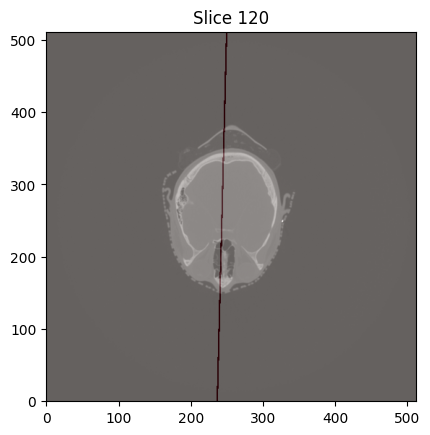

In [28]:
%matplotlib inline
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd

# -------------------------------------------------------
# LOAD CT + MIDLINE CSV
# -------------------------------------------------------
ct_path = r"Z:\FacialDeformation_MPhys\rhabdo_data_proton\DICOMS\abby\UIDQQ0x7axQ0Q1\CT.nii.gz"
csv_path = r"Z:\FacialDeformation_MPhys\rhabdo_data_proton\DICOMS\abby\UIDQQ0x7axQ0Q1\asymmetry\midline_pts.csv"

img = nib.load(ct_path)
data = img.get_fdata()
aff = img.affine

# Load your CSV (x y z with scientific notation)
pts = pd.read_csv(csv_path)

# -------------------------------------------------------
# CONVERT MIDLINE POINTS FROM RAS → VOXEL SPACE
# -------------------------------------------------------
aff_inv = np.linalg.inv(aff)

# extend points to homogeneous coords
pts_ras_h = np.hstack([pts, np.ones((pts.shape[0], 1))])
pts_vox = (aff_inv @ pts_ras_h.T).T[:, :3]

# -------------------------------------------------------
# PCA TO FIT MIDLINE PLANE IN VOXEL SPACE
# -------------------------------------------------------
centroid_vox = pts_vox.mean(axis=0)
U, S, Vt = np.linalg.svd(pts_vox - centroid_vox)
normal_vox = Vt[-1]   # plane normal in voxel coordinates


# -------------------------------------------------------
# FUNCTION: intersection mask for axial slice k
# -------------------------------------------------------
def plane_intersection_mask(k):
    Nx, Ny, Nz = data.shape
    
    ys, xs = np.mgrid[0:Ny, 0:Nx]   # note shape order
    zs = np.full_like(xs, k)

    pts = np.vstack([xs.flatten(), ys.flatten(), zs.flatten()]).T
    dist = np.abs((pts - centroid_vox) @ normal_vox)

    mask = dist.reshape(Ny, Nx).T  # transpose back
    return mask < 0.8              # tolerance for visibility


# -------------------------------------------------------
# INTERACTIVE VIEWER
# -------------------------------------------------------
fig, ax = plt.subplots()
k = data.shape[2] // 2  # start in the middle

img_ax = ax.imshow(data[:, :, k].T, cmap='gray', origin='lower')
plane = ax.imshow(plane_intersection_mask(k), cmap='Reds', alpha=0.4, origin='lower')

ax.set_title(f"Slice {k}")

def on_scroll(event):
    global k
    if event.button == 'up':
        k = min(k + 1, data.shape[2] - 1)
    elif event.button == 'down':
        k = max(k - 1, 0)
    img_ax.set_data(data[:, :, k].T)
    plane.set_data(plane_intersection_mask(k))
    ax.set_title(f"Slice {k}")
    fig.canvas.draw_idle()

fig.canvas.mpl_connect('scroll_event', on_scroll)
plt.show()
